In [115]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from datetime import datetime

In [116]:
wandb.init(project="Weather")

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,██▇▇▇▇▇▇▆▆▆▅▄▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,29
loss,16.03478


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [117]:
config = wandb.config
config.learning_rate = 0.001

Data

In [119]:
data = pd.read_csv('weatherHistory.csv')
data.head(5)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [120]:
data['Formatted Date']=pd.to_datetime(data['Formatted Date'], utc=True)
# calculate day of year 
data['Date'] = data['Formatted Date'].map(lambda date: date.year*10000 + date.month*100 + date.day)
data['DayOfYear']= data['Formatted Date'].dt.dayofyear
data.head(5)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,Date,DayOfYear
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,20060331,90
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,20060331,90
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,20060401,91
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,20060401,91
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,20060401,91


In [121]:
# Calculate mean temperature of each day in 24 hours
MeanTempEachDay = data.groupby(['Date','DayOfYear'])['Temperature (C)'].sum().reset_index()
MeanTempEachDay['Temperature (C)'] = MeanTempEachDay['Temperature (C)'] // 24
MeanTempEachDay.head(5)

,Date,DayOfYear,Temperature (C)
0,20051231,365,0.0
1,20060101,1,4.0
2,20060102,2,5.0
3,20060103,3,2.0
4,20060104,4,2.0


Text(0, 0.5, 'Temperature (C)')

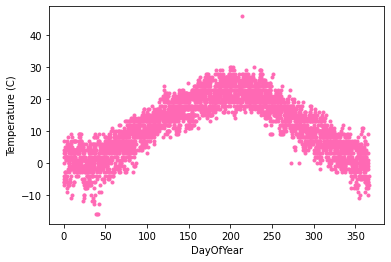

In [122]:
plt.scatter(MeanTempEachDay['DayOfYear'],MeanTempEachDay['Temperature (C)'] , c = 'hotpink',marker='.')
plt.xlabel('DayOfYear')
plt.ylabel('Temperature (C)')

In [131]:
X = MeanTempEachDay['DayOfYear'].values
Y= MeanTempEachDay['Temperature (C)'].values
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)

In [132]:
X_train, X_test , Y_train , Y_test = train_test_split(X ,Y ,shuffle=True)

### Model

In [133]:
model = tf.keras.models.Sequential([
    Dense(50, input_dim=1, activation='sigmoid'),
    Dense(100, activation='sigmoid'),
    Dense(200, activation='sigmoid'),
    Dense(1, activation="linear")
])

In [134]:
model.compile(optimizer=tf.keras.optimizers.Adam(config.learning_rate),
              loss = tf.keras.losses.MeanSquaredError()
              )

In [135]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 50)                100       
                                                                 
 dense_37 (Dense)            (None, 100)               5100      
                                                                 
 dense_38 (Dense)            (None, 200)               20200     
                                                                 
 dense_39 (Dense)            (None, 1)                 201       
                                                                 
Total params: 25,601
Trainable params: 25,601
Non-trainable params: 0
_________________________________________________________________


In [136]:
model.fit(X_train, Y_train, epochs=320, callbacks=[WandbCallback()])

Epoch 1/320
85/85 [==============================] - 1s 2ms/step - loss: 100.2149
Epoch 2/320
85/85 [==============================] - 0s 2ms/step - loss: 74.8644
Epoch 3/320
85/85 [==============================] - 0s 2ms/step - loss: 65.0622
Epoch 4/320
85/85 [==============================] - 0s 2ms/step - loss: 58.4429
Epoch 5/320
85/85 [==============================] - 0s 2ms/step - loss: 55.1413
Epoch 6/320
85/85 [==============================] - 0s 2ms/step - loss: 53.3681
Epoch 7/320
85/85 [==============================] - 0s 2ms/step - loss: 52.3938
Epoch 8/320
85/85 [==============================] - 0s 2ms/step - loss: 52.1215
Epoch 9/320
85/85 [==============================] - 0s 2ms/step - loss: 51.8706
Epoch 10/320
85/85 [==============================] - 0s 2ms/step - loss: 51.8033
Epoch 11/320
85/85 [==============================] - 0s 2ms/step - loss: 52.0411
Epoch 12/320
85/85 [==============================] - 0s 2ms/step - loss: 51.7610
Epoch 13/320
85/85 [====

[[ 0.82533264]
 [21.322657  ]
 [-0.29321384]
 ...
 [ 0.09178856]
 [ 5.684864  ]
 [21.349886  ]]


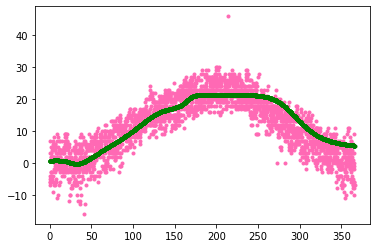

In [137]:
Y_pred = model.predict(X_train)

plt.scatter(X_train, Y_train, c ='hotpink' ,marker=".")
plt.plot(X_train, Y_pred, ".", c='g')

In [138]:
model.evaluate(X_test, Y_test)

29/29 [==============================] - 0s 1ms/step - loss: 20.1719


20.171855926513672